In [2]:
import pandas as pd

In [4]:
df_offers = pd.read_excel("/Users/HighOnOctave/Downloads/WineKMC.xlsx", sheet_name=0)

In [5]:
df_offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [6]:
df_offers.columns = ["offer_id","campaign","varietal","min_qty","discount","origin","past_peak"]

In [7]:
df_transactions = pd.read_excel("/Users/HighOnOctave/Downloads/WineKMC.xlsx", sheet_name=1)

In [8]:
df_transactions.head()

,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


In [9]:
df_transactions.columns = ["customer_name", "offer_id"]

In [10]:
df_transactions['n'] = 1

In [11]:
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


In [12]:
# Join offers and transactions table
df = pd.merge(df_offers, df_transactions)

In [13]:
#create pivot table which will give us the number of times each customer responded to the offer
matrix = df.pivot_table(index=['customer_name'],columns=['offer_id'], values='n')

In [16]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
#Fill NaN values and make index a column
matrix = matrix.fillna(0).reset_index()

In [17]:
#save a list of 0/1 column. It will be used later
x_cols = matrix.columns[1:]

In [53]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters = 5)

matrix['cluster'] =  cluster.fit_predict(matrix[matrix.columns[2:]])

matrix.cluster.value_counts()



1    36
4    33
3    16
2    12
0     3
Name: cluster, dtype: int64

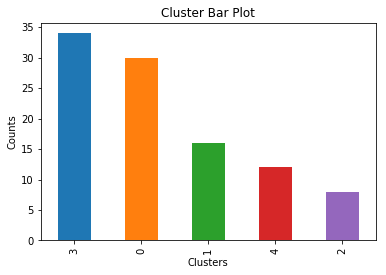

In [39]:
# Visualize as bar plot
import matplotlib.pyplot as plt
cp = matrix.cluster.value_counts().plot(kind="bar", title="Cluster Bar Plot")
cp.set_xlabel("Clusters")
cp.set_ylabel("Counts")
plt.show()

In [64]:
# Implementing PCA to reduce the dimensionality to 2 columns

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters =  matrix[['customer_name','cluster','x','y']]
customer_clusters.head()

offer_id,customer_name,cluster,x,y
0,Adams,1,1.007580,0.108215
1,Allen,4,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,1,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


In [90]:
df = pd.merge(df_transactions, customer_clusters)
df = pd.merge(df_offers, df)

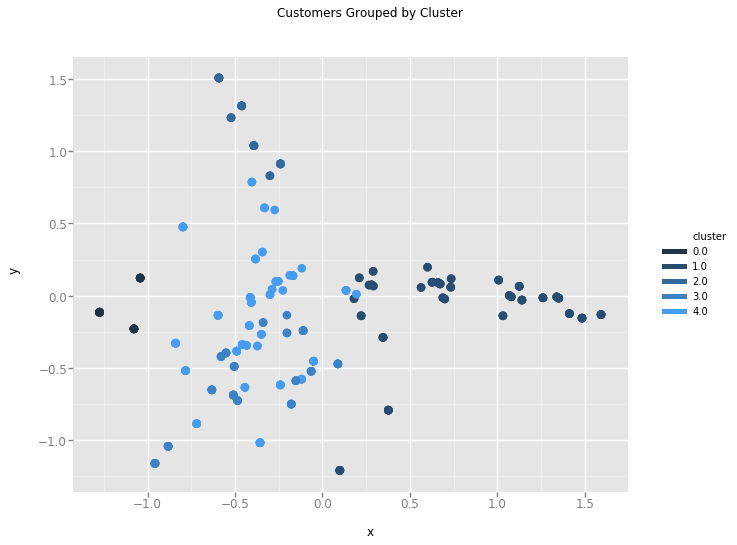

<ggplot: (-9223372029306072418)>

In [110]:
from ggplot import *

ggplot(df, aes(x='x', y='y', color='cluster')) + \
    geom_point(size=75) + \
    ggtitle("Customers Grouped by Cluster")

In [117]:
cluster_centers =  pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x','y'])
cluster_centers['cluster'] = range(0,len(cluster_centers))

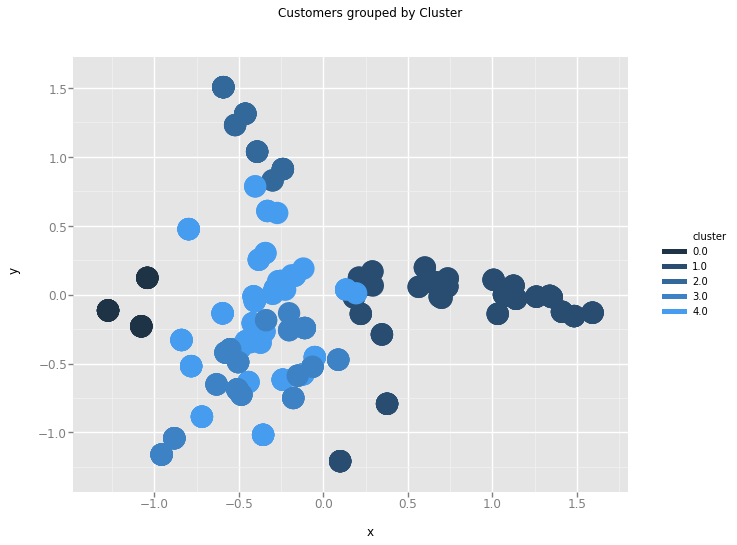

<ggplot: (-9223372029306207428)>

In [126]:
# Plot the clusters along with their centroids
ggplot(df, aes(x='x',y='y', color='cluster')) + \
    geom_point(size=75) + \
    geom_point(cluster_centers, size=500) + \
    ggtitle("Customers grouped by Cluster")

In [128]:
df['is_4'] = df.cluster==4

In [130]:
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Champagne             46
       Espumante             36
       Pinot Noir            35
       Prosecco              32
       Malbec                23
       Pinot Grigio          17
       Cabernet Sauvignon    15
       Merlot                11
       Chardonnay             5
True   Champagne             35
       Cabernet Sauvignon    17
       Prosecco              11
       Chardonnay            10
       Malbec                 9
       Merlot                 9
       Pinot Noir             9
       Espumante              4
Name: varietal, dtype: int64

In [131]:
df.groupby("is_4")[['min_qty','discount']].mean()

,min_qty,discount
is_4,,
False,46.309091,58.527273
True,84.000000,61.500000


In [132]:
df['is_3'] = df.cluster==3

In [133]:
df.groupby("is_3").varietal.value_counts()

is_3   varietal          
False  Champagne             49
       Pinot Noir            43
       Espumante             37
       Prosecco              34
       Malbec                27
       Cabernet Sauvignon    24
       Merlot                17
       Pinot Grigio          16
       Chardonnay            12
True   Champagne             32
       Prosecco               9
       Cabernet Sauvignon     8
       Malbec                 5
       Chardonnay             3
       Espumante              3
       Merlot                 3
       Pinot Grigio           1
       Pinot Noir             1
Name: varietal, dtype: int64

In [134]:
df.groupby("is_3")[['min_qty','discount']].mean()

,min_qty,discount
is_3,,
False,54.903475,57.640927
True,72.369231,66.815385
